In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import nltk
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn import svm
import numpy as np
from sklearn.ensemble import RandomForestClassifier

In [2]:
df = pd.read_csv("ca85.csv.gz",compression='gzip')
df.authorship.value_counts().head(30)

PER CURIAM    2074
TORRUELLA     1596
SELYA         1589
COFFIN        1401
LYNCH         1233
CAMPBELL      1195
ALDRICH       1080
BOWNES         973
BOUDIN         818
LIPEZ          755
STORY          729
STAHL          647
PUTNAM         647
BREYER         578
BINGHAM        577
WOODBURY       560
COLT           493
HOWARD         482
LOWELL         453
CYR            439
MAGRUDER       407
McENTEE        347
ANDERSON       298
BROWN          283
THOMPSON       268
CLIFFORD       263
WILSON         256
HARTIGAN       256
CURTIS         195
JOHNSON        190
Name: authorship, dtype: int64

In [3]:
df.loc[df.word_count<=50].opinion[379]

'The judgment of the District Court is affirmed.  \n\n'

In [4]:
df.authorship = df.authorship.str.upper()
allnames = df.authorship.value_counts().head(100).index

names = ['HOWARD','TORRUELLA','LYNCH','THOMPSON','KAYATTA','BARRON','CAMPBELL','SELYA','BOUDIN','STAHL','LIPEZ',
'COLT','PUTNAM','LOWELL','DODGE','BINGHAM','JOHNSON','ANDERSON','WILSON','MORTON','MAGRUDER',
'MAHONEY','WOODBURY','HARTIGAN','ALDRICH','MCENTEE','COFFIN','BOWNES','BREYER','CYR','SOUTER','STORY','BROWN','CLIFFORD',
       'SHEPLEY']
copy = pd.DataFrame()
temp = df[df.word_count > 50]
for name in names:
    copy = copy.append(temp[temp.authorship == name])
copy.date_standard = copy.date_standard.str[:4]
copy.date_standard = copy.date_standard.astype(int)
copy = copy.drop(columns=['opinion_type','opinion_id','word_count','authors','dc_source','judges_refined'])
copy

,dc_identifier,opinion,authorship,date_standard
12,4W05-D4D0-TXFX-32GG-00000-00,"HOWARD, Circuit Judge. Dwight John appeals fro...",HOWARD,2009
14,52ND-VH41-652P-Y061-00000-00,"HOWARD, Circuit Judge. In this insurance cover...",HOWARD,2011
24,7X5T-BXC0-YB0V-C00R-00000-00,"HOWARD, Circuit Judge. Plaintiff Luis Medina a...",HOWARD,2009
34,4CB7-H080-0038-X52P-00000-00,"HOWARD, Circuit Judge. Linda L. Lalonde and Ma...",HOWARD,2004
69,4CVR-J2W0-0038-X0YD-00000-00,"HOWARD, Circuit Judge. On May 6, 2002, Mary Go...",HOWARD,2004
...,...,...,...,...
22493,3S4X-3V10-003B-J258-00000-00,"SHEPLEY, Circuit Judge. Complainants claim un...",SHEPLEY,1875
22507,3S4X-43F0-003B-J3CJ-00000-00,"SHEPLEY, Circuit Judge. The complainant corpo...",SHEPLEY,1872
22509,3S4X-3WT0-003B-J2C3-00000-00,"SHEPLEY, Circuit Judge. This contract of bott...",SHEPLEY,1875
22510,3S4X-3XX0-003B-J2JJ-00000-00,"SHEPLEY, Circuit Judge. This suit is founded ...",SHEPLEY,1874


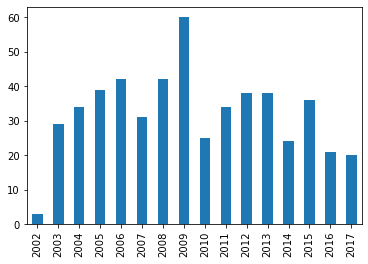

In [5]:
copy[copy.authorship == names[0]].date_standard.value_counts().sort_index().plot(kind='bar')

In [6]:
copy.opinion = copy.opinion.str.replace('Senior Circuit Judge','')
copy.opinion = copy.opinion.str.replace('Senior Circuit Judge'.upper(),'')
copy.opinion = copy.opinion.str.replace('Senior District Judge','')
copy.opinion = copy.opinion.str.replace('Senior District Judge'.upper(),'')
copy.opinion = copy.opinion.str.replace('Circuit Judges','')
copy.opinion = copy.opinion.str.replace('CIRCUIT JUDGES','')
copy.opinion = copy.opinion.str.replace('District Judge','')
copy.opinion = copy.opinion.str.replace('District Judge'.upper(),'')
copy.opinion = copy.opinion.str.replace('Circuit Judge','')
copy.opinion = copy.opinion.str.replace('CIRCUIT JUDGE','')
copy.opinion = copy.opinion.str.replace('Circuit Justice','')
copy.opinion = copy.opinion.str.replace('Circuit Justice'.upper(),'')
copy.opinion = copy.opinion.str.replace('Chief Judge',' ')
copy.opinion = copy.opinion.str.replace('Chief Judge'.upper(),' ')
copy.opinion = copy.opinion.str.replace('D\.J\.','')
copy.opinion = copy.opinion.str.replace('D\. J\.','')
copy.opinion = copy.opinion.str.replace('C\.J\.','')
copy.opinion = copy.opinion.str.replace('C\. J\.','')
copy.opinion = copy.opinion.str.replace('Senior Judge','')
copy.opinion = copy.opinion.str.replace('Senior Judge'.upper(),'')
copy.opinion = copy.opinion.str.replace('Associate Justice','')
copy.opinion = copy.opinion.str.replace('Associate Justice'.upper(),'')

for name in allnames:
    copy.opinion = copy.opinion.str.replace(name.upper(),'')
    copy.opinion = copy.opinion.str.replace(name,'')
    copy.opinion = copy.opinion.str.replace(name[:1].upper()+name[1:].lower(),'')

copy.opinion = copy.opinion.str.replace('McENTEE','')
copy.opinion = copy.opinion.str.replace('McEntee','')
copy.opinion = copy.opinion.str.replace('JOHN','')
copy.opinion = copy.opinion.str.replace('John','')
copy.opinion = copy.opinion.str.replace('\n',' ')

In [7]:
copy.opinion = copy.opinion.str.replace('\\\'','')
copy.opinion = copy.opinion.str.replace('(','')
copy.opinion = copy.opinion.str.replace(')','')
copy.opinion = copy.opinion.apply(lambda x: re.sub(r"\s\w\.", "", x))
copy.opinion = copy.opinion.apply(lambda x: re.sub(r"\s\.\s", " ", x))
copy.opinion = copy.opinion.apply(lambda x: re.sub(r"\s\.\s", " ", x))
copy.opinion = copy.opinion.apply(lambda x: re.sub(r"\s\,", ",", x))
copy.opinion = copy.opinion.apply(lambda x: re.sub(r"\d+", "", x))
copy.opinion = copy.opinion.apply(lambda x: re.sub(r"-", "", x))
copy.opinion = copy.opinion.str.replace('S\.C\.','')
copy.opinion = copy.opinion.str.replace('Ct\.','Ct')
copy.opinion = copy.opinion.str.replace('Ed\.','Ed')
copy.opinion = copy.opinion.str.replace('Dec\.','Dec')
copy.opinion = copy.opinion.str.replace(' No\.',' No')
copy.opinion = copy.opinion.str.replace(' pt\.',' pt')
copy.opinion = copy.opinion.str.replace(' Rep\.',' Rep')
copy.opinion = copy.opinion.str.replace(' Tr\.',' Tr')
copy.opinion = copy.opinion.str.replace(' Arg\.',' Arg')
copy.opinion = copy.opinion.str.replace(' Nev\.',' Nev')
copy.opinion = copy.opinion.str.replace(' Rev\.',' Rev')
copy.opinion = copy.opinion.str.replace(' Stat\.',' Stat')
copy.opinion = copy.opinion.str.replace(' Cent\.',' Cent')
copy.opinion = copy.opinion.str.replace(' Ore\.',' Ore')
copy.opinion = copy.opinion.str.replace(' Co\.',' Co')
copy.opinion = copy.opinion.str.replace(' Ins\.',' Ins')
copy.opinion = copy.opinion.str.replace('S\.','')
copy.opinion = copy.opinion.str.replace('Cf\.','Cf')
copy.opinion = copy.opinion.str.replace('Id\.','Id')
copy.opinion = copy.opinion.str.replace(' ,',',')
copy.opinion = copy.opinion.str.replace(' \.','.')
copy.opinion = copy.opinion.str.replace('§','')
copy.opinion = copy.opinion.str.replace('$','')
copy.opinion = copy.opinion.str.replace('\.\.','.')
copy.opinion = copy.opinion.str.replace('\.\.','.')
copy.opinion = copy.opinion.str.replace(',,',',')
copy.opinion = copy.opinion.str.replace(',,',',')
copy.opinion = copy.opinion.str.replace(',\.',',')
copy.opinion = copy.opinion.str.replace('"',' ')
copy.opinion = copy.opinion.str.replace('II','')
copy.opinion = copy.opinion.str.replace('III','')
copy.opinion = copy.opinion.str.replace('  ',' ')

In [8]:
# Prints the first 200 characters of the first 10 cleaned opinion texts of a given judge.
judge = 0
print(names[judge]+'\n')
for x in range(10):
    print(copy.opinion[copy.loc[copy.authorship==names[judge]].index[x]][:200]+'\n\n')

HOWARD

, Dwight appeals from the district courts denial of his habeas corpus petition. was convicted in Massachusetts Superior Court state trial court of firstdegree murder of Lezmore Buffong Alternate spell


, In this insurance coverage case, plaintiff Beatrice Hunt appeals the district courts grant of summary judgment to defendant Golden Rule Insurance Company on her claims of breach of contract and unfa


, Plaintiff Luis Medina appeals from the district courts entry of summary judgment in favor of defendant Metropolitan Life Insurance Company MetLife . Medina contends that MetLife violated the Employm


, Linda Lalonde and Machelle SimonGrech, acting on behalf of a putative class of participants in and beneficiaries of an employee stock ownership plan ESOP known as the Textron Savings Plan, brought l


, On May, Mary Gorsuch entered a branch of the Fleet Bank in Bangor, Maine; brandished an unloaded semiautomatic handgun; robbed three teller stations of a total of ,; and walked o

In [9]:
#get rough estimate for total number of top 10 authors in all 3 splits
top = 2000
bot = 1970
split1 = pd.DataFrame()
for x in copy[copy.date_standard<=bot].authorship.value_counts().head(10).index:
    temp = copy[copy.authorship == x]
    split1 = split1.append(temp[temp.date_standard<=bot])
split2 = pd.DataFrame()
for x in copy[copy.date_standard<top][copy.date_standard>bot].authorship.value_counts().head(10).index:
    temp = copy[copy.authorship == x]
    split2 = split2.append(temp[temp.date_standard<top][temp.date_standard>bot])
split3 = pd.DataFrame()
for x in copy[copy.date_standard>=top].authorship.value_counts().head(10).index:
    temp = copy[copy.authorship == x]
    split3 = split3.append(temp[temp.date_standard>=top])

for i in range(3):
    totalNum = split1.shape[0]+split2.shape[0]+split3.shape[0]
    print('totalNum = '+str(totalNum))
    print(split1.shape)
    print(split2.shape)
    print(split3.shape)    

    #initialize the splits so we can iterate over them
    top = 2020
    bot = 1800
    split1 = pd.DataFrame()
    for x in copy[copy.date_standard<=bot].authorship.value_counts().head(10).index:
        temp = copy[copy.authorship == x]
        split1 = split1.append(temp[temp.date_standard<=bot])
    split2 = pd.DataFrame()
    for x in copy[copy.date_standard<top][copy.date_standard>bot].authorship.value_counts().head(10).index:
        temp = copy[copy.authorship == x]
        split2 = split2.append(temp[temp.date_standard<top][temp.date_standard>bot])
    split3 = pd.DataFrame()
    for x in copy[copy.date_standard>=top].authorship.value_counts().head(10).index:
        temp = copy[copy.authorship == x]
        split3 = split3.append(temp[temp.date_standard>=top])
    
    
    
    
    #loop to iterate 
    while split1.shape[0] < totalNum/3:
        bot += 1
        split1 = pd.DataFrame()
        for x in copy[copy.date_standard<=bot].authorship.value_counts().head(10).index:
            temp = copy[copy.authorship == x]
            split1 = split1.append(temp[temp.date_standard<=bot])    
    while split3.shape[0] < totalNum/3:
        top -= 1
        split3 = pd.DataFrame()
        for x in copy[copy.date_standard>=top].authorship.value_counts().head(10).index:
            temp = copy[copy.authorship == x]
            split3 = split3.append(temp[temp.date_standard>=top])
    split2 = pd.DataFrame()
    for x in copy[copy.date_standard<top][copy.date_standard>bot].authorship.value_counts().head(10).index:
        temp = copy[copy.authorship == x]
        split2 = split2.append(temp[temp.date_standard<top][temp.date_standard>bot])
    

    print(split1.shape)
    print(split2.shape)
    print(split3.shape)
    print('top = '+str(top)+' bot = '+str(bot))

totalNum = 17106
(5021, 4)
(6501, 4)
(5584, 4)


c:\program files\python37\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:57: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:59: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


(5762, 4)
(4930, 4)
(5821, 4)
top = 1999 bot = 1980
totalNum = 16513
(5762, 4)
(4930, 4)
(5821, 4)
(5535, 4)
(5563, 4)
(5584, 4)
top = 2000 bot = 1978
totalNum = 16682
(5535, 4)
(5563, 4)
(5584, 4)
(5627, 4)
(5363, 4)
(5584, 4)
top = 2000 bot = 1979


# Bag of Words approach

## Split 1

In [10]:
split1.authorship.value_counts()

ALDRICH     789
STORY       727
PUTNAM      645
COFFIN      611
BINGHAM     576
WOODBURY    557
COLT        488
LOWELL      450
MAGRUDER    405
CAMPBELL    379
Name: authorship, dtype: int64

In [11]:
print('Number of Datapoints: ', split1.shape[0])

Number of Datapoints:  5627


In [12]:
split1names = split1.authorship.unique()

for index, name in enumerate(split1names):
    split1.authorship = split1.authorship.str.replace(name, str(index))
split1.authorship = split1.authorship.astype(int)

In [13]:
vectorizer1 = CountVectorizer(lowercase=False, ngram_range=(1,3), min_df=30, max_features=3000)
bowM1 = vectorizer1.fit_transform(split1.opinion)
#print(bowM1.toarray().shape)
#print(vectorizer1.get_feature_names())

In [14]:
X1 = pd.DataFrame.sparse.from_spmatrix(bowM1)
X1 = X1.sparse.to_dense()

In [15]:
for x in range(0,len(X1.columns)):
    mean = X1.iloc[:,x].mean()
    std = X1.iloc[:,x].std()
    X1.iloc[:,x] = (X1.iloc[:,x] - mean)/std

In [16]:
Y1 = split1.authorship.to_frame().reset_index().drop(columns=['index'])

X1_Training, X1_Testing, y1_Training, y1_Testing = train_test_split(X1, Y1, test_size=0.2, random_state=1234)

In [17]:
scores = [0,0,0,0,0]

for i in range(0,5):
    classifier = svm.SVC(kernel='poly',degree=1,C=1,class_weight='balanced', verbose=True, probability=True)

    X1_train, X1_test, y1_train, y1_test = train_test_split(X1_Training, y1_Training, test_size=0.2, random_state=i)
    classifier.fit(np.array(X1_train), np.array(y1_train))
    values = classifier.predict_proba(np.array(X1_test))
    
    correct = 0
    counter = 0
    for k in range(0,y1_test.size):
        if np.amax(values[k]) == values[k][int(y1_test.iloc[k])]:
            correct += 1
        counter += 1
        
    scores[i] = correct/counter
    print(scores[i])
    
print('Accuracy: ', np.array(scores).mean(), ' +/- ', np.array(scores).std())

c:\program files\python37\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


[LibSVM]0.8823529411764706


c:\program files\python37\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


[LibSVM]0.8801331853496115


c:\program files\python37\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


[LibSVM]0.8745837957824639


c:\program files\python37\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


[LibSVM]0.9001109877913429


c:\program files\python37\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


[LibSVM]0.876803551609323
Accuracy:  0.8827968923418424  +/-  0.009060302611302338


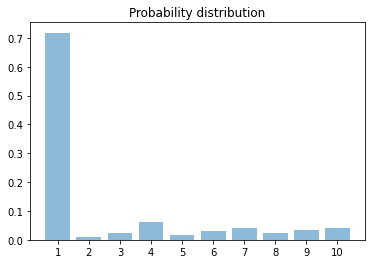

Accuracy:  0.8836589698046181


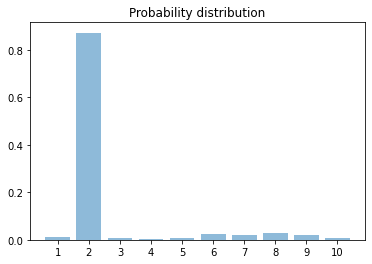

Accuracy:  0.8836589698046181


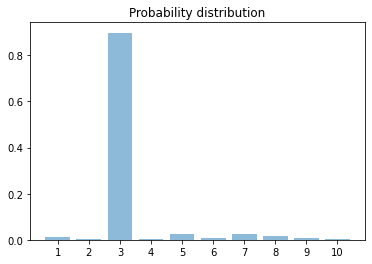

Accuracy:  0.8836589698046181


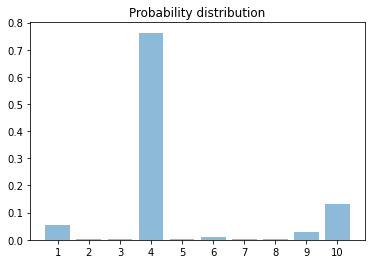

Accuracy:  0.8836589698046181


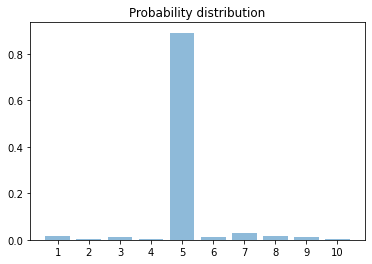

Accuracy:  0.8836589698046181


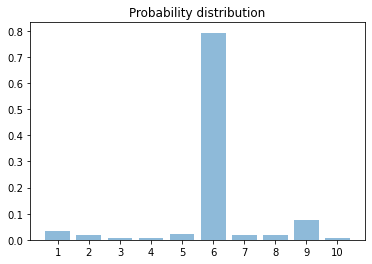

Accuracy:  0.8836589698046181


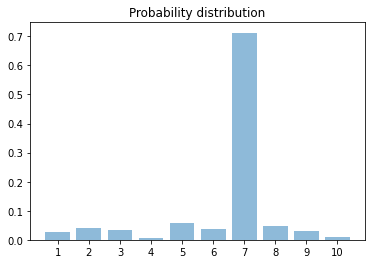

Accuracy:  0.8836589698046181


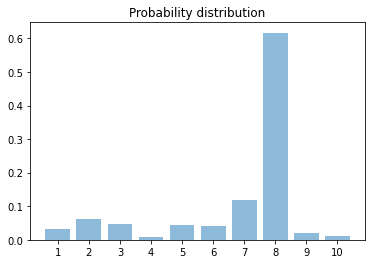

Accuracy:  0.8836589698046181


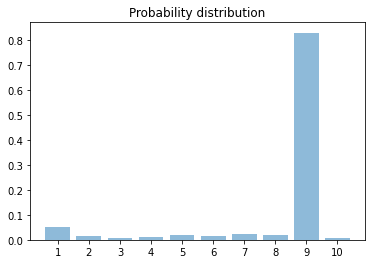

Accuracy:  0.8836589698046181


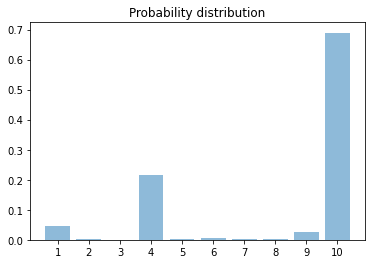

Accuracy:  0.8836589698046181


In [18]:
values1 = classifier.predict_proba(np.array(X1_Testing))
data1 = pd.DataFrame(data=values1)
data1['Y'] = y1_Testing.authorship.to_frame().reset_index().drop(columns=['index'])
data1.to_csv('85_split1_results.csv', index=False)

for l in range(0,10):
    probs = [0,0,0,0,0,0,0,0,0,0]
    count = 0

    for i,row in data1.iterrows():
        if(row['Y'] == l):
            for k in range(0,10):
                probs[k] += row[k]
            count += 1
    
    for k in range(0,10):
        probs[k] = probs[k]/count

    objects = ('1','2','3','4','5','6','7','8','9','10')
    y_pos = np.arange(len(objects))
    performance = probs

    plt.bar(y_pos, performance, align='center', alpha=0.5)
    plt.xticks(y_pos, objects)
    plt.title('Probability distribution')

    plt.show()
    
    correct = 0
    counter = 0
    for k in range(0,y1_Testing.size):
        if np.amax(values1[k]) == values1[k][int(y1_Testing.iloc[k])]:
            correct += 1
        counter += 1
        
    print('Accuracy: ',correct/counter)

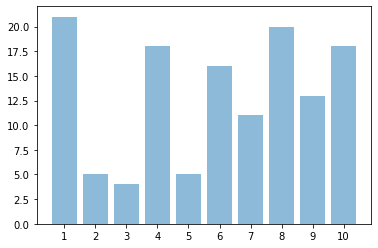

[21, 5, 4, 18, 5, 16, 11, 20, 13, 18]


In [19]:
wrongPredictions = [0,0,0,0,0,0,0,0,0,0]

for i,row in data1.iterrows():
    if row[int(row['Y'])] != np.amax(row[:10]):
        wrongPredictions[(int(row['Y']))] += 1
        #print(i)
        
objects = ('1','2','3','4','5','6','7','8','9','10')
y_pos = np.arange(len(objects))
performance = wrongPredictions

plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.show()

print(wrongPredictions)

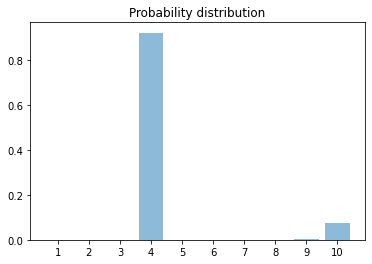

In [20]:
objects = ('1','2','3','4','5','6','7','8','9','10')
y_pos = np.arange(len(objects))
performance = values1[233]

plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.title('Probability distribution')

plt.show()

## Split 2

In [21]:
split2.authorship.value_counts()

BOWNES       771
SELYA        727
CAMPBELL     714
TORRUELLA    712
COFFIN       671
BREYER       577
CYR          343
BOUDIN       298
ALDRICH      291
STAHL        259
Name: authorship, dtype: int64

In [22]:
print('Number of Datapoints: ', split2.shape[0])

Number of Datapoints:  5363


In [23]:
split2names = split2.authorship.unique()

for index, name in enumerate(split2names):
    split2.authorship = split2.authorship.str.replace(name, str(index))
split2.authorship = split2.authorship.astype(int)

In [24]:
vectorizer2 = CountVectorizer(lowercase=False, ngram_range=(1,3), min_df=30, max_features=3000)
bowM2 = vectorizer2.fit_transform(split2.opinion)
#print(bowM2.toarray().shape)
#print(vectorizer2.get_feature_names())

In [25]:
X2 = pd.DataFrame.sparse.from_spmatrix(bowM2)
X2 = X2.sparse.to_dense()

In [26]:
for x in range(0,len(X2.columns)):
    mean = X2.iloc[:,x].mean()
    std = X2.iloc[:,x].std()
    X2.iloc[:,x] = (X2.iloc[:,x] - mean)/std

In [27]:
Y2 = split2.authorship.to_frame().reset_index().drop(columns=['index'])

X2_Training, X2_Testing, y2_Training, y2_Testing = train_test_split(X2, Y2, test_size=0.2, random_state=1234)

In [28]:
scores = [0,0,0,0,0]

for i in range(0,5):
    classifier = svm.SVC(kernel='poly',degree=1,C=1,class_weight='balanced', verbose=True, probability=True)

    X2_train, X2_test, y2_train, y2_test = train_test_split(X2_Training, y2_Training, test_size=0.2, random_state=i)
    classifier.fit(np.array(X2_train), np.array(y2_train))
    values = classifier.predict_proba(np.array(X2_test))
    
    correct = 0
    counter = 0
    for k in range(0,y2_test.size):
        if np.amax(values[k]) == values[k][int(y2_test.iloc[k])]:
            correct += 1
        counter += 1
        
    scores[i] = correct/counter
    print(scores[i])
    
print('Accuracy: ', np.array(scores).mean(), ' +/- ', np.array(scores).std())

c:\program files\python37\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


[LibSVM]0.7972027972027972


c:\program files\python37\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


[LibSVM]0.7505827505827506


c:\program files\python37\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


[LibSVM]0.7738927738927739


c:\program files\python37\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


[LibSVM]0.7668997668997669


c:\program files\python37\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


[LibSVM]0.7750582750582751
Accuracy:  0.7727272727272727  +/-  0.015034513283540411


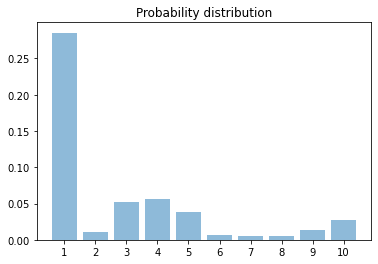

Accuracy:  0.7399813606710158


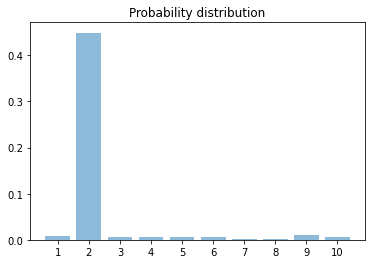

Accuracy:  0.7399813606710158


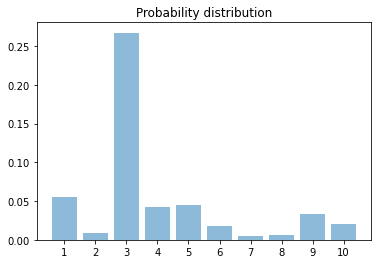

Accuracy:  0.7399813606710158


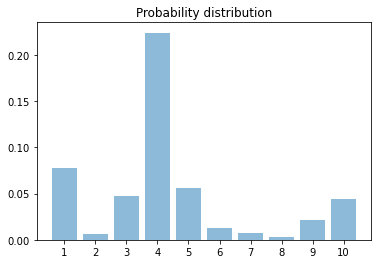

Accuracy:  0.7399813606710158


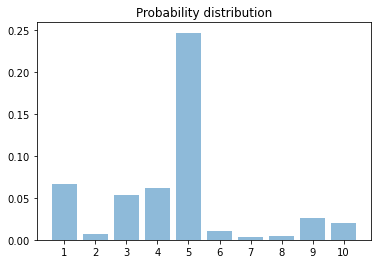

Accuracy:  0.7399813606710158


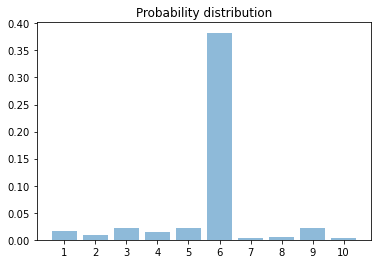

Accuracy:  0.7399813606710158


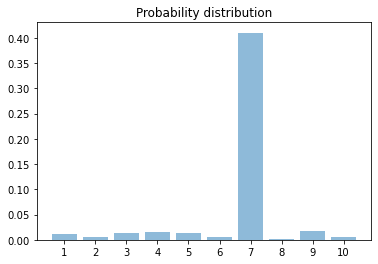

Accuracy:  0.7399813606710158


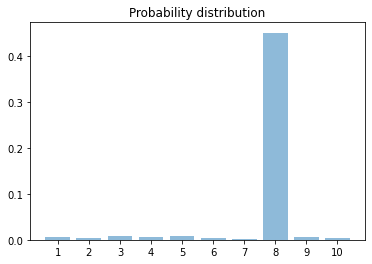

Accuracy:  0.7399813606710158


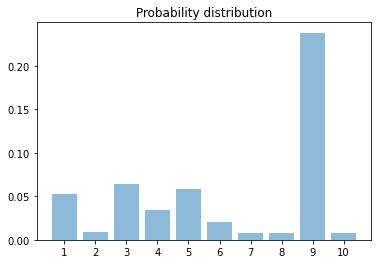

Accuracy:  0.7399813606710158


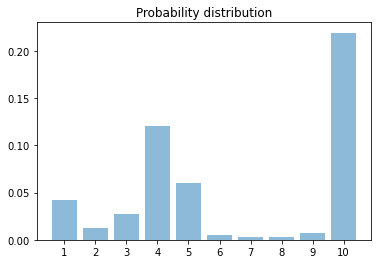

Accuracy:  0.7399813606710158


In [29]:
values2 = classifier.predict_proba(np.array(X2_Testing))
data2 = pd.DataFrame(data=values2)
data2['Y'] = y2_Testing.authorship.to_frame().reset_index().drop(columns=['index'])
data2.to_csv('85_split2_results.csv', index=False)

for l in range(0,10):
    probs = [0,0,0,0,0,0,0,0,0,0]
    count = 0

    for i,row in data2.iterrows():
        if(row['Y'] == l):
            count += 1
            for k in range(0,10):
                probs[k] += row[k]
            count += 1

    for k in range(0,10):
        probs[k] = probs[k]/count

    objects = ('1','2','3','4','5','6','7','8','9','10')
    y_pos = np.arange(len(objects))
    performance = probs

    plt.bar(y_pos, performance, align='center', alpha=0.5)
    plt.xticks(y_pos, objects)
    plt.title('Probability distribution')

    plt.show()
    
    correct = 0
    counter = 0
    for k in range(0,y2_Testing.size):
        if np.amax(values2[k]) == values2[k][int(y2_Testing.iloc[k])]:
            correct += 1
        counter += 1
        
    print('Accuracy: ',correct/counter)

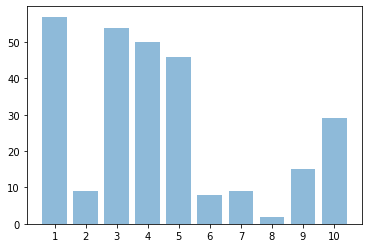

[57, 9, 54, 50, 46, 8, 9, 2, 15, 29]


In [30]:
wrongPredictions = [0,0,0,0,0,0,0,0,0,0]

for i,row in data2.iterrows():
    if row[int(row['Y'])] != np.amax(row[:10]):
        wrongPredictions[(int(row['Y']))] += 1
        #print(i)
        
objects = ('1','2','3','4','5','6','7','8','9','10')
y_pos = np.arange(len(objects))
performance = wrongPredictions

plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.show()

print(wrongPredictions)

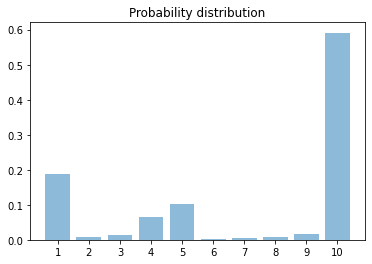

In [31]:
objects = ('1','2','3','4','5','6','7','8','9','10')
y_pos = np.arange(len(objects))
performance = values2[233]

plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.title('Probability distribution')

plt.show()

## Split 3

In [32]:
split3.authorship.value_counts()

LYNCH        1079
TORRUELLA     887
SELYA         874
LIPEZ         724
BOUDIN        525
HOWARD        516
STAHL         389
THOMPSON      271
KAYATTA       180
BARRON        139
Name: authorship, dtype: int64

In [33]:
print('Number of Datapoints: ', split3.shape[0])

Number of Datapoints:  5584


In [34]:
split3names = split3.authorship.unique()

for index, name in enumerate(split3names):
    split3.authorship = split3.authorship.str.replace(name, str(index))
split3.authorship = split3.authorship.astype(int)

In [35]:
vectorizer3 = CountVectorizer(lowercase=False, ngram_range=(1,3), min_df=30, max_features=3000)
bowM3 = vectorizer3.fit_transform(split3.opinion)
#print(bowM3.toarray().shape)
#print(vectorizer3.get_feature_names())

In [36]:
X3 = pd.DataFrame.sparse.from_spmatrix(bowM3)
X3 = X3.sparse.to_dense()

In [37]:
for x in range(0,len(X3.columns)):
    mean = X3.iloc[:,x].mean()
    std = X3.iloc[:,x].std()
    X3.iloc[:,x] = (X3.iloc[:,x] - mean)/std

In [38]:
Y3 = split3.authorship.to_frame().reset_index().drop(columns=['index'])

X3_Training, X3_Testing, y3_Training, y3_Testing = train_test_split(X3, Y3, test_size=0.2, random_state=1234)

In [39]:
scores = [0,0,0,0,0]

for i in range(0,5):
    classifier = svm.SVC(kernel='poly',degree=1,C=1,class_weight='balanced', verbose=True, probability=True)

    X3_train, X3_test, y3_train, y3_test = train_test_split(X3_Training, y3_Training, test_size=0.2, random_state=i)
    classifier.fit(np.array(X3_train), np.array(y3_train))
    values = classifier.predict_proba(np.array(X3_test))
    
    correct = 0
    counter = 0
    for k in range(0,y3_test.size):
        if np.amax(values[k]) == values[k][int(y3_test.iloc[k])]:
            correct += 1
        counter += 1
        
    scores[i] = correct/counter
    print(scores[i])
    
print('Accuracy: ', np.array(scores).mean(), ' +/- ', np.array(scores).std())

c:\program files\python37\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


[LibSVM]0.7874720357941835


c:\program files\python37\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


[LibSVM]0.7762863534675615


c:\program files\python37\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


[LibSVM]0.7595078299776287


c:\program files\python37\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


[LibSVM]0.7550335570469798


c:\program files\python37\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


[LibSVM]0.7516778523489933
Accuracy:  0.7659955257270694  +/-  0.013670349993245802


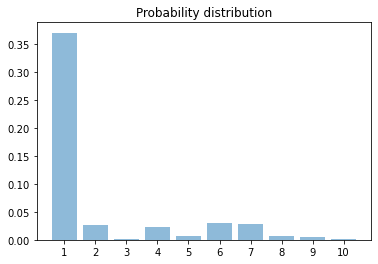

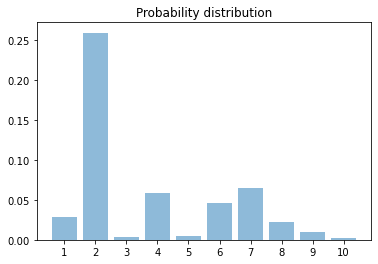

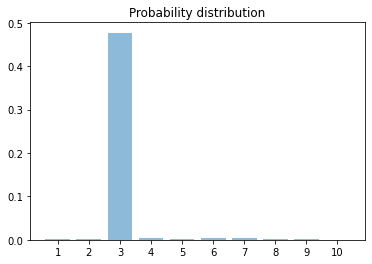

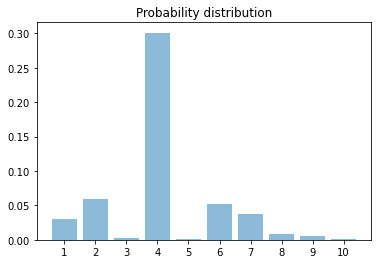

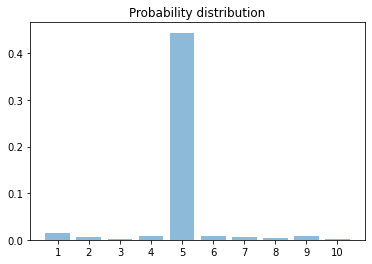

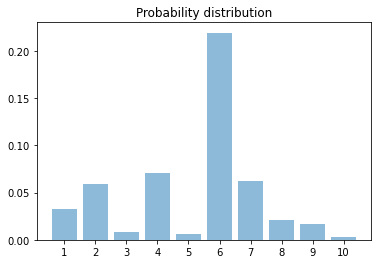

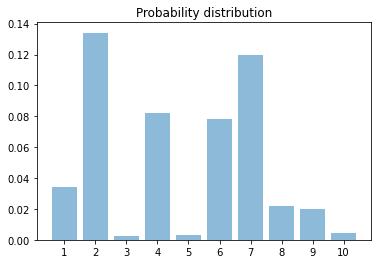

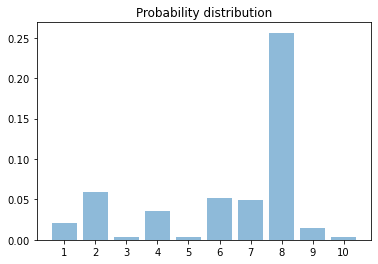

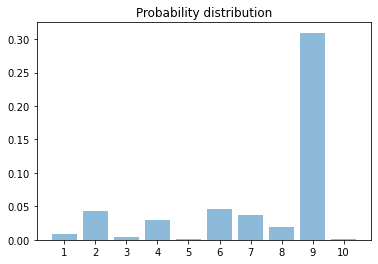

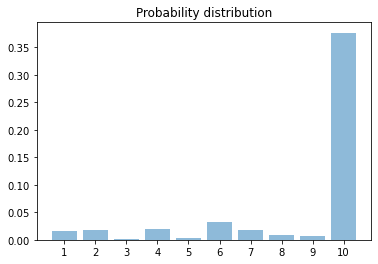

In [40]:
values3 = classifier.predict_proba(np.array(X3_Testing))
data3 = pd.DataFrame(data=values3)
data3['Y'] = y3_Testing.authorship.to_frame().reset_index().drop(columns=['index'])
data3.to_csv('85_split3_results.csv', index=False)

for l in range(0,10):
    probs = [0,0,0,0,0,0,0,0,0,0]
    count = 0

    for i,row in data3.iterrows():
        if(row['Y'] == l):
            count += 1
            for k in range(0,10):
                probs[k] += row[k]
            count += 1

    for k in range(0,10):
        probs[k] = probs[k]/count

    objects = ('1','2','3','4','5','6','7','8','9','10')
    y_pos = np.arange(len(objects))
    performance = probs

    plt.bar(y_pos, performance, align='center', alpha=0.5)
    plt.xticks(y_pos, objects)
    plt.title('Probability distribution')

    plt.show()

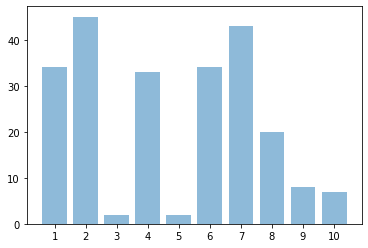

[34, 45, 2, 33, 2, 34, 43, 20, 8, 7]


In [41]:
wrongPredictions = [0,0,0,0,0,0,0,0,0,0]

for i,row in data3.iterrows():
    if row[int(row['Y'])] != np.amax(row[:10]):
        wrongPredictions[(int(row['Y']))] += 1
        #print(i)
        
objects = ('1','2','3','4','5','6','7','8','9','10')
y_pos = np.arange(len(objects))
performance = wrongPredictions

plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.show()

print(wrongPredictions)

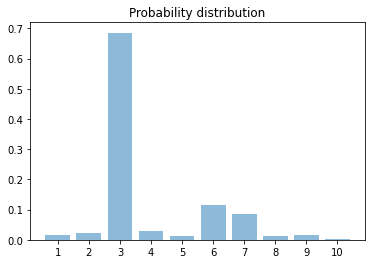

In [42]:
objects = ('1','2','3','4','5','6','7','8','9','10')
y_pos = np.arange(len(objects))
performance = values3[233]

plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.title('Probability distribution')

plt.show()

# Function word approach
-> https://pythonprogramming.net/natural-language-toolkit-nltk-part-speech-tagging/

Articles = DT,PDT, WDT<br />
Pronouns = PRP, PRP\\$, WP, WP\$<br />
Conjunctions = CC<br />
Particles = RP<br />
Adpositions (Preposition) = IN<br />
Interjections = UH

Maybe = EX, MD (moda could,will), TO

Nops = CD, FW, JJx, NNx, (POS), RBx, VBx, WRB

In [43]:
import nltk
from nltk import word_tokenize
from nltk.tag import perceptron 
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')
tagger = perceptron.PerceptronTagger()


[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Cyril\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping taggers\averaged_perceptron_tagger.zip.
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Cyril\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [44]:
tags = ['DT','PDT','WDT','PRP','PRP$','WP','WP$','CC','RP','IN','UH','EX','MD','TO']

split1['tagged'] = split1['opinion'].apply(lambda row: tagger.tag(word_tokenize(row)))

In [45]:
def funcword(row):
    functionwords = []
    for (word,tag) in row:
        if(tag in tags):
            functionwords.append(word.lower())
    return functionwords
            
split1['funcWords'] = split1['tagged'].apply(lambda row: funcword(row))
split1['funcWords'] = split1['funcWords'].apply(lambda l: " ".join(l))

In [46]:
vectorizerFW = CountVectorizer(lowercase=False, ngram_range=(1,1), min_df=40)
X_FW = vectorizerFW.fit_transform(split1['funcWords'])

In [47]:
X4 = pd.DataFrame.sparse.from_spmatrix(X_FW)
X4 = X4.sparse.to_dense()

In [48]:
for x in range(0,len(X4.columns)):
    mean = X4.iloc[:,x].mean()
    std = X4.iloc[:,x].std()
    X4.iloc[:,x] = (X4.iloc[:,x] - mean)/std

In [49]:
Y4 = split1.authorship.to_frame().reset_index().drop(columns=['index'])

X4_Training, X4_Testing, y4_Training, y4_Testing = train_test_split(X4, Y4, test_size=0.2, random_state=1234)

In [50]:
scores = [0,0,0,0,0]

for i in range(0,5):
    classifier = svm.SVC(kernel='poly',degree=1,C=1,class_weight='balanced', verbose=True, probability=True)

    X4_train, X4_test, y4_train, y4_test = train_test_split(X4_Training, y4_Training, test_size=0.2, random_state=i)
    classifier.fit(np.array(X4_train), np.array(y4_train))
    values = classifier.predict_proba(np.array(X4_test))
    
    correct = 0
    counter = 0
    for k in range(0,y4_test.size):
        if np.amax(values[k]) == values[k][int(y4_test.iloc[k])]:
            correct += 1
        counter += 1
        
    scores[i] = correct/counter
    print(scores[i])
    
print('Accuracy: ', np.array(scores).mean(), ' +/- ', np.array(scores).std())

c:\program files\python37\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


[LibSVM]0.6936736958934517
[LibSVM]

c:\program files\python37\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


0.7081021087680355
[LibSVM]

c:\program files\python37\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


0.6748057713651499
[LibSVM]

c:\program files\python37\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


0.6736958934517203
[LibSVM]

c:\program files\python37\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


0.6881243063263041
Accuracy:  0.6876803551609323  +/-  0.012763113439702581
